## Deep RNN para Time Series + 10 Steps En un Solo Batch

In [1]:
import warnings
warnings.filterwarnings('ignore')

import keras 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import tensorflow as tf

Using TensorFlow backend.


#### Generacion de series temporales Artificiales

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) 
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)  
    return series[..., np.newaxis].astype(np.float32)

In [3]:
n_steps = 50
series = generate_time_series(10000, n_steps + 10)

series.shape

(10000, 60, 1)

#### Creacion del Test y Train Set

In [4]:
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]


print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)

(7000, 50, 1) (7000, 10)
(2000, 50, 1) (2000, 10)


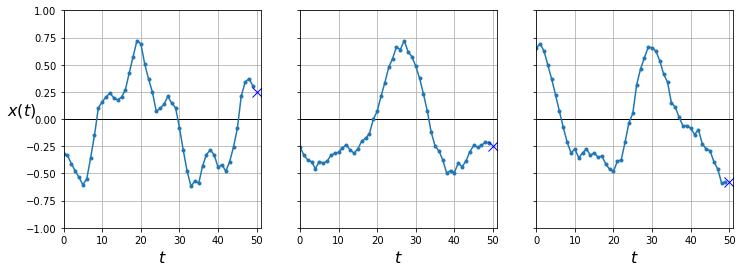

In [11]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], Y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
plt.show()

### Entreamiento con Deep SimpleRNN

Esta red construye una RNN con varas capas de celulas RNN. No hay necesidad de especificar el tamano del input shape ya que puede procesar cadenas de cualquier tamano. 

Algunas cosas:
- Esta red usa por defecto la funcion de activacion de Tangente Hiperbolica.
- el estado inicial de $h_{(t)} es 0$
- $h_{(t)}$ se comporta se retroalimenta la neurona con informacion anterior.
- por defecto keras solamente retorna el valor del ultimo step t. 
- para devolver sequencias se debe definir return_sequences = True

**Nota**

- todas las capas retornan return_sequences = True excepto la ultima

In [12]:
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))


Train on 7000 samples, validate on 2000 samples
Epoch 1/20


InternalError: 2 root error(s) found.
  (0) Internal: Blas GEMM launch failed : a.shape=(32, 1), b.shape=(1, 20), m=32, n=20, k=1
	 [[{{node simple_rnn_1/while/MatMul}}]]
	 [[Mean/_91]]
  (1) Internal: Blas GEMM launch failed : a.shape=(32, 1), b.shape=(1, 20), m=32, n=20, k=1
	 [[{{node simple_rnn_1/while/MatMul}}]]
0 successful operations.
0 derived errors ignored.

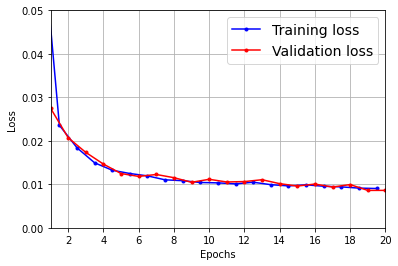

In [12]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

### Generar 10 steps adicionales.

In [9]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]

Y_new.shape

#Y_pred = model.predict(X_new)[..., np.newaxis]

(1, 10, 1)

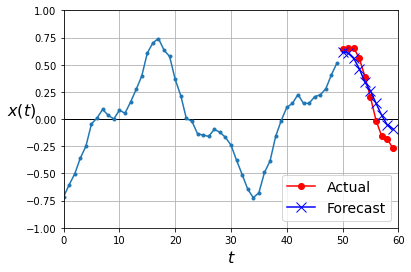

In [14]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()